CODE BLOCK: 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torchinfo import summary
from matplotlib import pyplot as plt
from tqdm import tqdm

CODE BLOCK: 2

In [2]:
mps = torch.backends.mps.is_available()
cuda = torch.cuda.is_available()
device = "cpu"
if cuda:
    device = torch.device("cuda")
elif mps:
    device = torch.device("mps")

device

device(type='mps')

CODE BLOCK: 3

In [3]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(11), ], p=0.4),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

In [5]:
batch_size = 64

kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 0, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

CODE BLOCK: 6

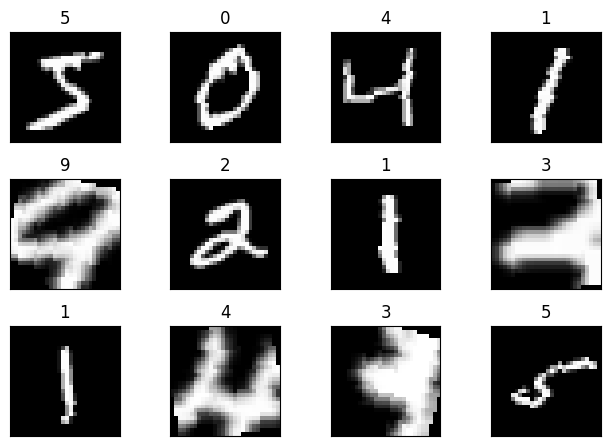

In [6]:
batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [7]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        x = self.gap(x)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [8]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [32, 26, 26]              320
├─Conv2d: 1-2                            [64, 24, 24]              18,496
├─Conv2d: 1-3                            [128, 10, 10]             73,856
├─Conv2d: 1-4                            [256, 8, 8]               295,168
├─AdaptiveAvgPool2d: 1-5                 [256, 1, 1]               --
├─Linear: 1-6                            [1, 50]                   12,850
├─Linear: 1-7                            [1, 10]                   510
Total params: 401,200
Trainable params: 401,200
Non-trainable params: 0
Total mult-adds (M): 727.73
Input size (MB): 0.00
Forward/backward pass size (MB): 0.70
Params size (MB): 1.60
Estimated Total Size (MB): 2.31

CODE BLOCK: 8

In [9]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [10]:
def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.inference_mode():
        for _, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            test_loss+=loss.item()

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [11]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [32, 26, 26]              320
├─Conv2d: 1-2                            [64, 24, 24]              18,496
├─Conv2d: 1-3                            [128, 10, 10]             73,856
├─Conv2d: 1-4                            [256, 8, 8]               295,168
├─AdaptiveAvgPool2d: 1-5                 [256, 1, 1]               --
├─Linear: 1-6                            [1, 50]                   12,850
├─Linear: 1-7                            [1, 10]                   510
Total params: 401,200
Trainable params: 401,200
Non-trainable params: 0
Total mult-adds (M): 727.73
Input size (MB): 0.00
Forward/backward pass size (MB): 0.70
Params size (MB): 1.60
Estimated Total Size (MB): 2.31

In [12]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

/Users/kaustubh/.virtualenvs/era/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


Train: Loss=0.2720 Batch_id=937 Accuracy=50.92: 100%|██████████| 938/938 [00:17<00:00, 53.45it/s]


Test set: Average loss: 0.0072, Accuracy: 8518/10000 (85.18%)

Epoch 2


Train: Loss=0.2419 Batch_id=937 Accuracy=85.11: 100%|██████████| 938/938 [00:16<00:00, 55.35it/s]


Test set: Average loss: 0.0038, Accuracy: 9240/10000 (92.40%)

Epoch 3


Train: Loss=0.2042 Batch_id=937 Accuracy=90.09: 100%|██████████| 938/938 [00:17<00:00, 54.17it/s]


Test set: Average loss: 0.0019, Accuracy: 9613/10000 (96.13%)

Epoch 4


Train: Loss=0.1268 Batch_id=937 Accuracy=92.22: 100%|██████████| 938/938 [00:17<00:00, 54.96it/s]


Test set: Average loss: 0.0032, Accuracy: 9311/10000 (93.11%)

Epoch 5


Train: Loss=0.0555 Batch_id=937 Accuracy=93.02: 100%|██████████| 938/938 [00:17<00:00, 54.32it/s]


Test set: Average loss: 0.0011, Accuracy: 9757/10000 (97.57%)

Epoch 6


Train: Loss=0.0188 Batch_id=937 Accuracy=93.80: 100%|██████████| 938/938 [00:16<00:00, 55.44it/s]


Test set: Average loss: 0.0007, Accuracy: 9849/10000 (98.49%)

Epoch 7


Train: Loss=0.0854 Batch_id=937 Accuracy=94.04: 100%|██████████| 938/938 [00:16<00:00, 56.44it/s]


Test set: Average loss: 0.0011, Accuracy: 9794/10000 (97.94%)

Epoch 8


Train: Loss=0.0116 Batch_id=937 Accuracy=94.58: 100%|██████████| 938/938 [00:16<00:00, 56.47it/s]


Test set: Average loss: 0.0008, Accuracy: 9836/10000 (98.36%)

Epoch 9


Train: Loss=0.0253 Batch_id=937 Accuracy=94.79: 100%|██████████| 938/938 [00:16<00:00, 55.88it/s]


Test set: Average loss: 0.0010, Accuracy: 9803/10000 (98.03%)

Epoch 10


Train: Loss=0.0623 Batch_id=937 Accuracy=95.25: 100%|██████████| 938/938 [00:16<00:00, 55.22it/s]


Test set: Average loss: 0.0006, Accuracy: 9857/10000 (98.57%)

Epoch 11


Train: Loss=0.0484 Batch_id=937 Accuracy=95.43: 100%|██████████| 938/938 [00:16<00:00, 56.27it/s]


Test set: Average loss: 0.0006, Accuracy: 9868/10000 (98.68%)

Epoch 12


Train: Loss=0.0689 Batch_id=937 Accuracy=95.54: 100%|██████████| 938/938 [00:16<00:00, 55.44it/s]


Test set: Average loss: 0.0007, Accuracy: 9860/10000 (98.60%)

Epoch 13


Train: Loss=0.1137 Batch_id=937 Accuracy=95.69: 100%|██████████| 938/938 [00:16<00:00, 55.29it/s]


Test set: Average loss: 0.0008, Accuracy: 9821/10000 (98.21%)

Epoch 14


Train: Loss=0.0983 Batch_id=937 Accuracy=95.78: 100%|██████████| 938/938 [00:16<00:00, 55.80it/s]


Test set: Average loss: 0.0005, Accuracy: 9891/10000 (98.91%)

Epoch 15


Train: Loss=0.0527 Batch_id=937 Accuracy=95.91: 100%|██████████| 938/938 [00:16<00:00, 55.52it/s]


Test set: Average loss: 0.0007, Accuracy: 9835/10000 (98.35%)

Epoch 16


Train: Loss=0.0352 Batch_id=937 Accuracy=96.70: 100%|██████████| 938/938 [00:16<00:00, 55.27it/s]


Test set: Average loss: 0.0004, Accuracy: 9914/10000 (99.14%)

Epoch 17


Train: Loss=0.0189 Batch_id=937 Accuracy=96.86: 100%|██████████| 938/938 [00:16<00:00, 55.31it/s]


Test set: Average loss: 0.0004, Accuracy: 9918/10000 (99.18%)

Epoch 18


Train: Loss=0.0178 Batch_id=937 Accuracy=96.86: 100%|██████████| 938/938 [00:16<00:00, 55.78it/s]


Test set: Average loss: 0.0004, Accuracy: 9917/10000 (99.17%)

Epoch 19


Train: Loss=0.0159 Batch_id=937 Accuracy=96.93: 100%|██████████| 938/938 [00:16<00:00, 55.51it/s]


Test set: Average loss: 0.0003, Accuracy: 9924/10000 (99.24%)

Epoch 20


Train: Loss=0.0041 Batch_id=937 Accuracy=96.96: 100%|██████████| 938/938 [00:16<00:00, 55.57it/s]


Test set: Average loss: 0.0004, Accuracy: 9920/10000 (99.20%)



CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

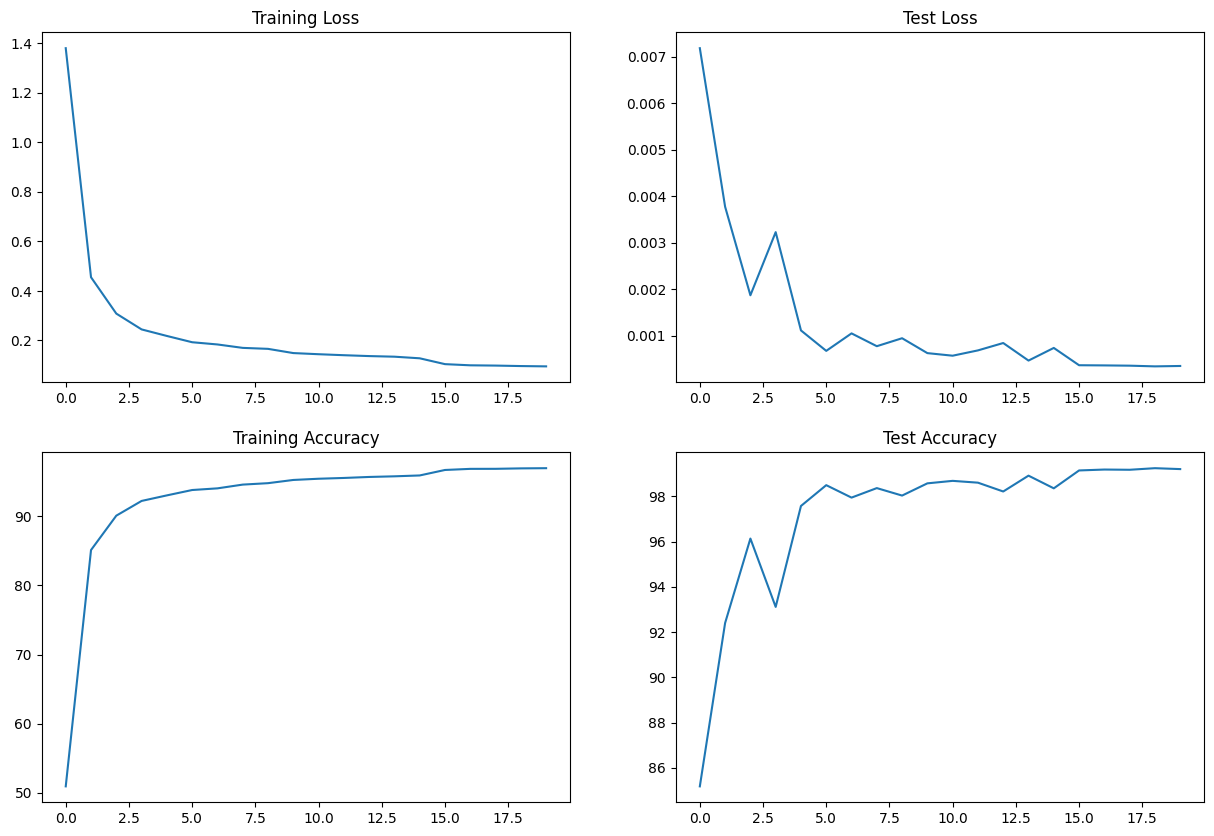

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")